# Predictive Analytic Tool for Precipitation (PATP)

The Predictive Analytic Tool for Precipitation (PATP) aims to harness historical weather data to predict precipitation for any given GPS location and specified time. By leveraging machine learning algorithms and comprehensive datasets, this project seeks to provide precise and actionable forecasts, tailored to specific geographic coordinates.

## Data Collection

The NASA POWER (Prediction of Worldwide Energy Resource) data service provides an extensive collection of meteorological and solar data, which can be harnessed for various applications, including our precipitation prediction tool.

First importing the necessary libraries:

In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, requests
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Fetching Weather Data from NASA POWER API
The NASA POWER (Prediction Of Worldwide Energy Resource) project provides global meteorological data, which can be leveraged for various applications including weather predictions, climate studies, and more.

In this section, we define a Python function named get_weather_data. The function's primary role is to fetch weather data based on specified latitude and longitude, and other optional parameters.
## Purpose: 
To fetch and return weather data from the NASA POWER API based on the given coordinates and parameters.

### Inputs:

latitude (float): The latitude of the desired location.
longitude (float): The longitude of the desired location.
parameters (str, optional): A comma-separated list of weather parameters to fetch. Defaults include temperature, dew point, and precipitation among others.
start_time (str, optional): The start date for fetching data in YYYYMMDD format.
end_time (str, optional): The end date for fetching data in YYYYMMDD format.

In [2]:

def get_weather_data(latitude, longitude, 
                     parameters='T2M,T2MDEW,T2MWT,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR',
                     start_time='20000101', 
                     end_time='20230101'):
    """
    Fetch weather data from NASA POWER API for the specified latitude, longitude, and parameters.

    Parameters:
    - latitude (float): Latitude of the location
    - longitude (float): Longitude of the location
    - parameters (str): Comma-separated list of weather parameters to fetch
    - start_time (str): Start date in YYYYMMDD format
    - end_time (str): End date in YYYYMMDD format

    Returns:
    - pd.DataFrame: A DataFrame containing the fetched weather data
    """
    
    # Construct the API request URL
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    query_parameters = {
        'parameters': parameters,
        'community': 'RE',
        'longitude': longitude,
        'latitude': latitude,
        'start': start_time,
        'end': end_time,
        'format': 'JSON'
    }
    api_request_url = f"{base_url}?{'&'.join([f'{key}={value}' for key, value in query_parameters.items()])}"

    try:
        # Make the GET request to the POWER API
        response = requests.get(url=api_request_url, verify=True, timeout=30.00)
        response.raise_for_status()  # Raise an HTTPError if the HTTP request returned an unsuccessful status code

        # Parse the JSON response content
        content = response.json()
        
        # Ensure the response contains the required data
        if "properties" in content and "parameter" in content["properties"]:
            data = content["properties"]["parameter"]
            # Convert the data to a Pandas DataFrame and return it
            df = pd.DataFrame(data)
            # Convert the index to a proper date format
            df.index = pd.to_datetime(df.index)
            return df
        else:
            print("Error: Missing data in API response.")
            return None

    except requests.RequestException as e:
        print(f"Error fetching data from NASA POWER API: {e}")
        return None

# Test the function
# df = get_weather_data(40.7128, -74.0060)
# print(df.head())


To start we focus on the following GPS locatoin which is located in the Pacific Ocean, west of Central America.

In [3]:
latitude, longitude = 10, -130
df = get_weather_data(latitude, longitude,parameters='T2M,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR')

df.head()

,T2M,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR
2000-01-01,24.62,20.51,24.65,0.31,24.76,24.46,3.83
2000-01-02,24.21,21.66,24.26,0.33,24.39,24.06,5.80
2000-01-03,23.91,21.51,23.93,0.27,24.04,23.76,4.85
2000-01-04,23.68,20.72,23.65,0.20,23.76,23.55,1.95
2000-01-05,23.41,21.19,23.49,0.26,23.57,23.32,16.68


## Summary Statistics:

In [4]:
df.describe()

,T2M,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR
count,8402.000000,8402.000000,8402.000000,8402.000000,8402.000000,8402.000000,8402.000000
mean,26.411951,23.208678,27.162937,0.567266,26.668290,26.101151,7.981082
std,0.849176,1.000260,1.029345,0.296404,0.875389,0.843467,10.803025
min,23.050000,18.480000,23.330000,0.100000,23.520000,22.430000,0.000000
25%,25.910000,22.600000,26.500000,0.350000,26.150000,25.600000,1.130000
50%,26.510000,23.330000,27.300000,0.490000,26.770000,26.200000,4.130000
75%,27.010000,23.910000,27.930000,0.710000,27.290000,26.690000,10.807500
max,28.900000,25.980000,30.050000,2.450000,29.200000,28.770000,166.340000


We don't have any missing data. 
Histograms to understand the distribution of each variable:


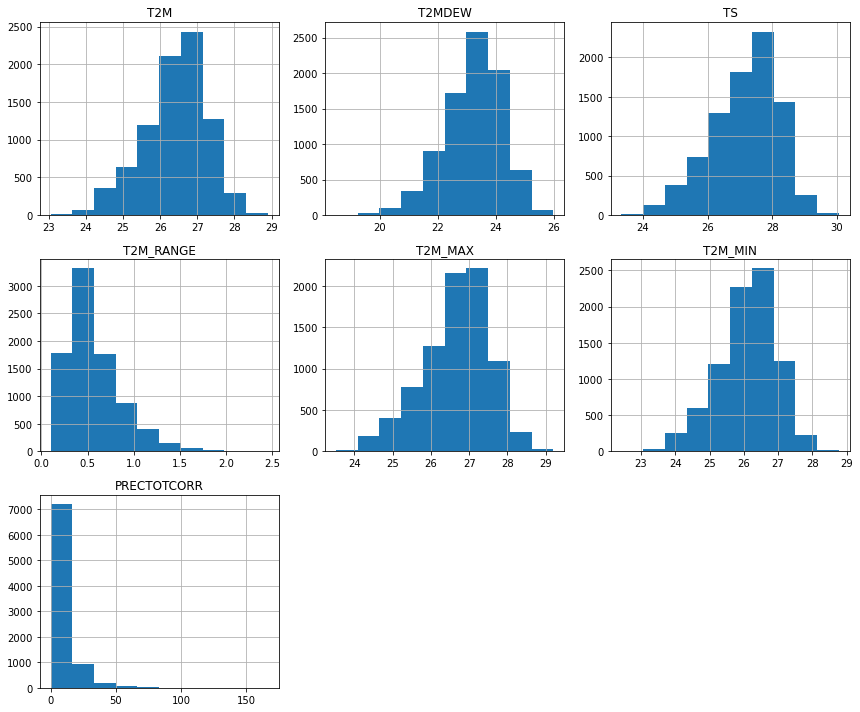

In [5]:
df.hist(figsize=(12, 10))
plt.tight_layout()

## Correlation Matrix: 
This helps to see if there are any potential linear relationships between our dependent variable PRECTOTCORR and independent variables.

<AxesSubplot:>

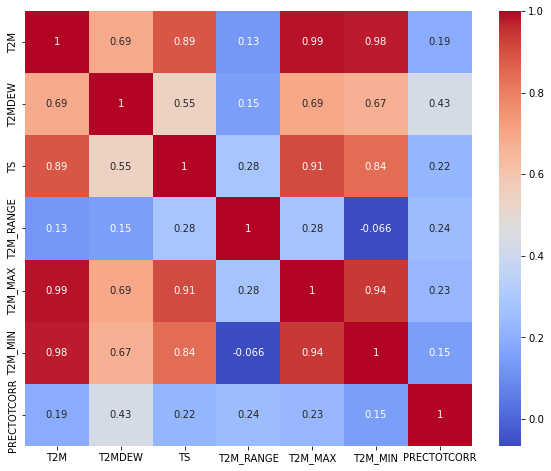

In [6]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [7]:
correlation_matrix

,T2M,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR
T2M,1.000000,0.690845,0.885529,0.127508,0.985658,0.978220,0.190433
T2MDEW,0.690845,1.000000,0.545427,0.147959,0.694046,0.668399,0.430306
TS,0.885529,0.545427,1.000000,0.282578,0.906723,0.841754,0.224135
T2M_RANGE,0.127508,0.147959,0.282578,1.000000,0.275246,-0.065801,0.244721
T2M_MAX,0.985658,0.694046,0.906723,0.275246,1.000000,0.941151,0.227062
T2M_MIN,0.978220,0.668399,0.841754,-0.065801,0.941151,1.000000,0.149768
PRECTOTCORR,0.190433,0.430306,0.224135,0.244721,0.227062,0.149768,1.000000


### Diagonal Values: 
All the diagonal values are 1, which is expected since any variable is perfectly correlated with itself.

### Correlation with PRECTOTCORR:

T2MDEW has the highest correlation (0.430306) with PRECTOTCORR, suggesting that as dew point temperature rises, the precipitation might also increase.
T2M_RANGE also has a fairly significant correlation with PRECTOTCORR at 0.244721.
The other variables (T2M, TS, T2M_MAX, T2M_MIN) have relatively lower correlations with PRECTOTCORR.
High Correlations between Independent Variables:

### Multicollinearity:
There's a very high correlation between T2M and T2M_MAX (0.985658), and between T2M and T2M_MIN (0.978220). This suggests multicollinearity, which can be problematic in linear regression models because it can make the model unstable. You might consider removing one of the highly correlated variables when modeling or using regularization techniques like Ridge or Lasso regression.
Low or Negative Correlations:

The correlation between T2M_RANGE and T2M_MIN is negative (-0.065801), though it's close to zero. This is intuitive as a higher range would likely correspond with lower minimum temperatures.

Let's drop T2M_MAX, T2M_MIN to avoid multicollinearity:

In [8]:
df = df.drop(['T2M_MIN', 'T2M_MAX'], axis=1)

## Time Seris plot

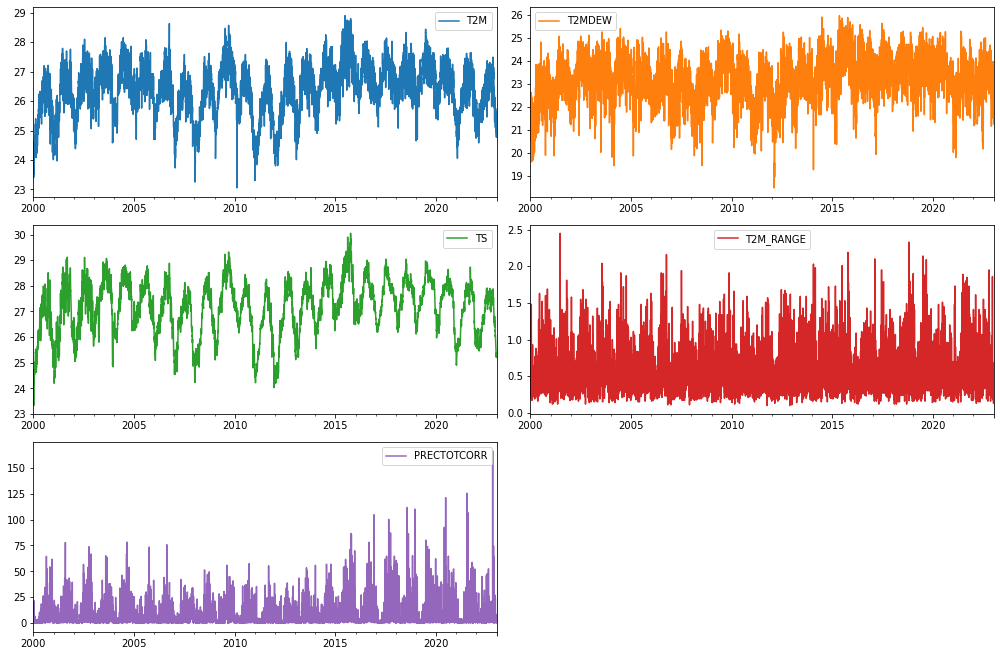

In [9]:
df.plot(subplots=True, layout=(4,2), figsize=(14,12), sharex=False)
plt.tight_layout()


## Boxplots: 
Identify potential outliers in each variable.

(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'T2M'),
  Text(2, 0, 'T2MDEW'),
  Text(3, 0, 'TS'),
  Text(4, 0, 'T2M_RANGE'),
  Text(5, 0, 'PRECTOTCORR')])

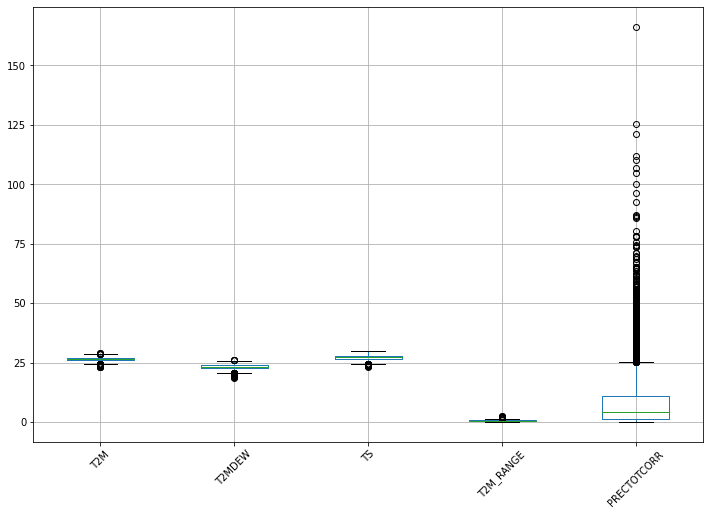

In [10]:
df.boxplot(figsize=(12,8))
plt.xticks(rotation=45)

After visualizing the data distribution of PRECTOTCORR using a box plot, it's evident that this variable exhibits high variance.

## Scatter plots

C:\Users\rasna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


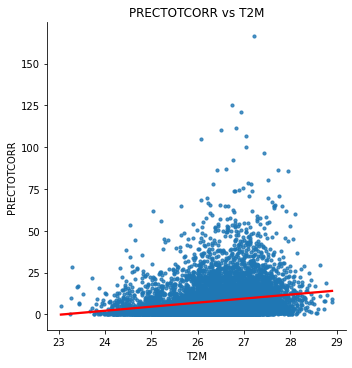

C:\Users\rasna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


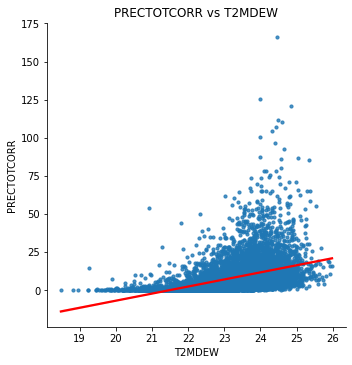

C:\Users\rasna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


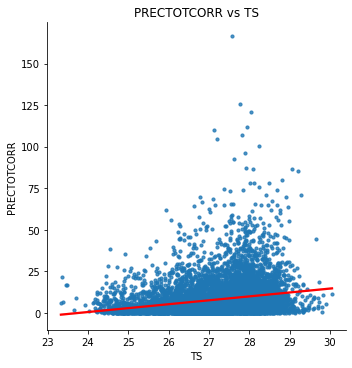

C:\Users\rasna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


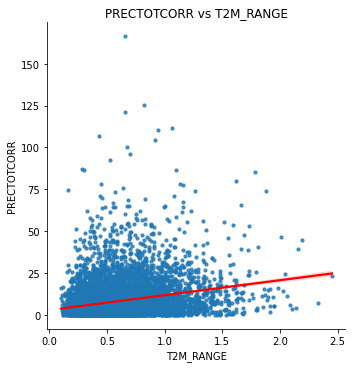

In [18]:
features = df.columns[:-1]  # excluding 'PRECTOTCORR'
for feature in features:
    sns.lmplot(feature, 'PRECTOTCORR', data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.title(f"PRECTOTCORR vs {feature}")
    plt.xlabel(feature)
    plt.ylabel('PRECTOTCORR')
    plt.show()

# Multiple Linear Regression analysis using scikit-learn
First, you'll need to split your data into predictor variables (X) and the target variable (y).

In [26]:
X = df.drop('PRECTOTCORR', axis=1) # droping the target variable
y = df['PRECTOTCORR']

## Split the Data into Training and Testing Sets:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Build the Model:

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predict the train and test sets

In [40]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [41]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAE: {mae}')

RMSE: 9.398027338842153
R^2 Score: 0.2715322192121835
MAE: 5.754034108155001


In [43]:
X_train.head()

,T2M,T2MDEW,TS,T2M_RANGE
2022-02-02,25.38,23.23,25.83,0.59
2008-11-10,26.05,23.47,27.07,0.73
2010-01-26,26.19,22.64,27.12,0.64
2009-08-14,27.28,24.73,28.72,1.33
2007-07-24,25.99,22.54,27.12,0.72


In [44]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [46]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAE: {mae}')

RMSE: 9.832358088966997
R^2 Score: 0.20264391297038387
MAE: 5.829395517651726
